# FA24 - Assignment 4 - **Style Transfer**

Instructions
* Download the `images.zip` dataset from Moodle.
* Do **NOT** forget to type in your name and AUBNET After this cell.
* Do **NOT** upload the dataset with your submission.
* **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**
* Name the assignment as follows: **Style_Transfer_AUBNET.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.
* Notebooks with no output will not be graded
* You are not allowed to Add, Edit, or delete any of the given headers/ Libraries.

**CMPS 364 - Advanced Machine Learning**

**Assignment 4 Part III - Computer Vision - Style Transfer**

**By - Ralph Mouawad - rmm85 - 202204667**

**To - Dr. Shady Elbassuoni**

# Introduction
In this assignment, you will implement neural style transfer to recreate specific content in a chosen artistic style. For example, you might generate cat images in the style of Ukiyo-e art. The algorithm takes three images as input: a content image, a style image, and an initial input image, which is optimized to align with the content and style characteristics of the target images.

In the first part, you’ll begin with random noise and optimize it within the content space, allowing you to familiarize yourself with pixel optimization based on specific loss functions. In the second part, you’ll focus solely on style, disregarding content temporarily, and generating textures to develop an intuitive understanding of style-space distance through the Gram matrix. Finally, you’ll combine all these components to complete the neural style transfer.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from PIL import Image
import torch.optim as optim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imgsize = 512 if torch.cuda.is_available() else 128  # Use a smaller size if GPU is unavailable, to enable easier testing on CPU

loader = transforms.Compose([
    transforms.Resize(imgsize),  # Scale the imported image
    transforms.ToTensor()])   # Convert it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

if torch.cuda.is_available():
        print('Models moved to GPU.')

def load_image(img_name):
    image = Image.open(img_name)
    # Add a fake batch dimension to match the network's input requirements
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def img_show(tensor, title=None):
    image = tensor.cpu().clone()  # Clone the tensor to avoid modifying the original
    image = image.squeeze(0)  # Remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Pause briefly to allow plots to update

"""
Furthermore, VGG networks are trained on images with each channel normalized
to a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225].
We will apply this normalization to the image before feeding it into the network.
"""

cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean=cnn_norm_mean, std=cnn_norm_std):
        super(Normalization, self).__init__()
        # Reshape the mean and standard deviation to be of shape [C x 1 x 1]
        # so they can be applied directly to an image tensor with shape [B x C x H x W].
        # Here, B represents the batch size, C is the number of channels,
        # H is the height, and W is the width.
        # self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.mean = mean.clone().detach().view(-1, 1, 1)
        # self.std = torch.tensor(std).view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # Normalize the photo pixels
        return (img - self.mean) / self.std


def get_img_optimizer(input_image):
    # We recommend using the L-BFGS optimizer to adjust the target image.
    # Set up an optimizer for the pixel values of the input image,
    # ensuring that gradients are required for the input_image.
    optimizer = optim.LBFGS([input_image])
    return optimizer

Models moved to GPU.


In [2]:
!unzip '/content/images.zip' -d '/content/images'

Archive:  /content/images.zip
   creating: /content/images/images/
  inflating: /content/images/__MACOSX/._images  
   creating: /content/images/images/content/
  inflating: /content/images/__MACOSX/images/._content  
   creating: /content/images/images/style/
  inflating: /content/images/__MACOSX/images/._style  
  inflating: /content/images/images/content/fallingwater.png  
  inflating: /content/images/__MACOSX/images/content/._fallingwater.png  
  inflating: /content/images/images/content/wally.jpg  
  inflating: /content/images/__MACOSX/images/content/._wally.jpg  
  inflating: /content/images/images/content/dancing.jpg  
  inflating: /content/images/__MACOSX/images/content/._dancing.jpg  
  inflating: /content/images/images/content/phipps.jpeg  
  inflating: /content/images/__MACOSX/images/content/._phipps.jpeg  
  inflating: /content/images/images/content/tubingen.jpeg  
  inflating: /content/images/__MACOSX/images/content/._tubingen.jpeg  
  inflating: /content/images/images/sty

# Content Reconstruction

In this first part of the assignment, you'll implement a content-space loss function to optimize random noise based on content loss alone.

Content Loss: The content loss measures the difference in content between two images at a specific layer. Let $f_x^L$ represent the feature map of the input image $X$ at layer $L$, and $f_C^L$ represent the feature map of the target content image at the same layer. The content loss is defined as the squared L2-distance between these two features: $|| f^L_X - f^L_C \|^2_2$.

Implement Content Loss in Code:

## Content Loss

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer's input. The computed loss is saved as a
parameter of the module.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Content_Error_Loss(nn.Module):

    def __init__(self, targ,):
        super(Content_Error_Loss, self).__init__()
        # To detach the target content feature maps F_CL from the gradient computation graph,
        # we use the `detach()` method. This ensures the gradients are not tracked for the content
        # feature maps, preventing them from being updated during backpropagation.
        #############################
        ### Your code starts here ###
        #############################

        self.target = targ.detach() # we dont want to update target features but optimize the input image to match this target


        #############################
        ### Your code ends here   ###
        #############################


    def forward(self, input):
        # This function should act as a passthrough, saving the calculated loss value as needed.
        #############################
        ### Your code starts here ###
        #############################

        self.loss = F.mse_loss(input, self.target) # calculte mse between feature maps of images 'G' and 'C'

        #############################
        ### Your code ends here   ###
        #############################

        return input

# Gram matrix
The Gram matrix is normalized by dividing each element by the total number of elements in the matrix. This normalization counteracts the effect of large values in the Gram matrix that arise when $\hat{F}_{XL}$ has a large $N$ dimension. Without normalization, early layers (those before pooling) could have a disproportionately large impact during gradient descent. Since style features are typically found in deeper layers, this normalization step is essential.


How do we measure the distance between the styles of two images? The [Gram matrix](http://mlwiki.org/index.php/Gram_Matrices) serves as a measure of style. The Gram matrix represents the correlation between two vectors across all dimensions. Specifically, let the $k$-th dimension of the $L$-th layer feature of an image be denoted as $F^L_k$ with a shape of $ (N, K, H \times W)$. The Gram matrix is defined as $G = f^L_k (f^L_k)^T$ with a shape of $(N, K, K)$. The goal is to ensure that the Gram matrices of our optimized and target features are as similar as possible.


In [4]:
#### Gram matrix
# Gram matrix wiki: http://mlwiki.org/index.php/Gram_Matrices
def gram_matrix(activations):
    a, b, c, d = activations.size()  # a = batch size (equal to 1)
    # b = number of feature maps
    # (c, d) = dimensions of a feature map (N = c * d)
    #############################
    ### Your code starts here ###
    #############################

    features = activations.view(a*b, c*d) # flatten every feature map and stack them as rows
    gram = torch.mm(features, features.t()) # compute gram matrix as F.F^T
    #############################
    ### Your code ends here   ###
    #############################

    # Normalize the values of the Gram matrix
    # by dividing by the number of elements in each feature map.
    ##############################
    ### Your code starts here ###
    #############################
    normalized_gram = gram.div(a*b*c*d)

    #############################
    ### Your code ends here   ###
    #############################

    return normalized_gram


# Style Loss

Style Loss: The style loss module is implemented similarly to the content loss module, functioning as a transparent layer in the network to compute style loss at a given layer. To calculate style loss, we first compute the Gram matrix $G_{XL}$. A Gram matrix is obtained by multiplying a matrix with its transpose. Here, the matrix is a reshaped version of the feature maps $F_{XL}$ from layer $L$. We reshape $F_{XL}$ into $\hat{F}_{XL}$, a $K \times N$ matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the length of any vectorized feature map $F_{XL}^k$. For instance, the first row of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.


Please implement the style loss below:

In [5]:
class Style_Error_Loss(nn.Module):

    def __init__(self, tg_feature):
        super(Style_Error_Loss, self).__init__()
        # Detach and cache the necessary components.
        #############################
        ### Your code starts here ###
        #############################


        self.target_gram = gram_matrix(tg_feature).detach() # gram matrix of target style image and detach to not update

        #############################
        ### Your code ends here   #
        #############################



    def forward(self, input):
        # Cache the relevant loss value in self.loss.
        #############################
        ### Your code starts here ###
        #############################

        # Get Gram matrix of input image
        input_gram = gram_matrix(input)

        # style loss
        self.loss = F.mse_loss(input_gram, self.target_gram)

        #############################
        ### Your code ends here   ###
        #############################


        return input


# Feature Extraction and Loss Insertion

When $L=0$￼, content loss simply reduces to an L2 pixel loss, which doesn't capture higher-level content information. Content loss, however, operates in feature space, capturing meaningful patterns within the image. To extract these features, we use a pre-trained VGG-19 network from ImageNet, which consists of 5 blocks (conv1–conv5), each serving as a feature extractor at different levels of abstraction.

The pre-trained VGG-19 model (vgg19) can be imported directly from the `torchvision.models` module. We'll use only its feature extraction layers (`model.features`) and set the model to `eval()` mode. Insert code to attach content loss modules to the end of specific layers (which we'll specify later) for optimization.

A `Sequential` module holds an ordered list of child modules. For example, `vgg19.features` contains a sequence of layers (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) arranged in the correct depth order. We need to add content loss and style loss layers directly after the convolution layers they are monitoring. To achieve this, we create a new `Sequential` module that inserts the content loss and style loss modules at the appropriate positions.

In [6]:
import os
import sys
import time
import copy
import math
import argparse

import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Target depth layers for computing style and content losses:
content_default_layers = ['conv_4']
style_default_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

weight_style = 200000  # Weight for the style loss
weight_content = 1     # Weight for the content loss

def get_model_and_losses(cnn_model, style_image, content_image,
                               content_layers=content_default_layers,
                               style_layers=style_default_layers):
    cnn_model = copy.deepcopy(cnn_model)

    # build a sequential model consisting of a Normalization layer
    # then all the layers of the VGG feature network along with Content_Loss and Style_Loss
    # layers in the specified places

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_loss_errors = []
    style_loss_errors = []

    # Assuming that cnn_model is an nn.Sequential, we create a new nn.Sequential
    # to incorporate modules that need to be activated in sequence.
    # If a nn.ReLU layer is required, ensure to set inplace=False,
    # as the in-place version may interfere with the loss layers.
    # Remove any layers after the last content and style losses,
    # as they are unnecessary.

    #############################
    ### Your code starts here ###
    #############################
    normalization = Normalization(cnn_norm_mean, cnn_norm_std) # normalize images with values from VGGNet
    model = nn.Sequential(normalization)

    i=0 # counter for layer's index
    for layer in cnn_model.children():
        if isinstance(layer, nn.Conv2d):
          i+=1
          name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          layer = nn.ReLU(inplace=False) # remove it to keep all information
        elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)

        model.add_module(name, layer) # add the layer to the model

        # check for content loss
        if name in content_layers:
            target = model(content_image).detach() # pass the content image in the model. detach to keep gradients as they are
            content_loss = Content_Error_Loss(target) # get the content loss with the target
            model.add_module("content_loss_{}".format(i), content_loss)
            content_loss_errors.append(content_loss)

        # check for style loss
        if name in style_layers: # same explanation
            target_feature = model(style_image).detach()
            style_loss = Style_Error_Loss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_loss_errors.append(style_loss)

    for i in range(len(model) -1, -1, -1):

      if isinstance(model[i], (Content_Error_Loss, Style_Error_Loss)):
        break
      model = model[:i+1]

      # backward iteration to find last content or style loss layer
      # retain only the model at this layer as the others are not needed for computations


    #############################
    ### Your code ends here   ###
    #############################


    return model, style_loss_errors, content_loss_errors


# Optimization

In this assignment, we keep the neural network fixed and optimize the pixel values of the input image. We use the quasi-Newton optimizer LBFGS for this purpose, initialized as `optimizer = optim.LBFGS([input_image.requires_grad_()])`. The LBFGS optimizer reevaluates the function multiple times, so instead of a straightforward `loss.backward()`, we need to define a closure hook that accomplishes the following tasks:
  1. clear the gradients
  2. compute the loss and its gradient
  3. return the loss.

Please complete the `run_optim` function and the `closure function` within.


In the below cell,  we need to define a function that executes the neural transfer process. In each iteration, the network receives an updated input and computes new losses. We will call the backward methods of each loss module to dynamically calculate their gradients. The optimizer also requires a “closure” function that reevaluates the module and returns the loss.

Additionally, we must address one final constraint: the network might optimize the input to exceed the 0 to 1 tensor range typically expected for images. We can resolve this by ensuring that the input values are clamped between 0 and 1 each time the network is executed.

In [17]:
def run_optim(cnn, content_image, style_image, input_image, use_content=True, use_style=True, number_steps=300,
                     weight_style=1000000, weight_content=1):
    print('Constructing the model…')
    # Obtain your model along with the loss modules.

    # Set up the optimizer.

    # Begin model training, keeping one important consideration in mind:
    # We recommend using the LBFGS optimizer, which preconditions the gradient
    # using an approximate Hessian derived from gradient evaluations of the function.
    # This means the optimizer may call your function multiple times per step to
    # numerically estimate the second derivative of the gradients (the Hessian).
    # Therefore, you need to define a function:
    # def closure():
    # here
    # which performs the following tasks:
    # - Clear the gradients
    # - Compute the loss and its gradient
    # - Return the loss

    # A final tip: ensure that the image values are within the range [0, 1],
    # but the optimizer is unaware of this, so you'll need to clamp the image values
    # to this range after every optimization step.


    #############################
    ### Your code starts here ###
    #############################

    model, style_losses, content_losses = get_model_and_losses(cnn, style_image, content_image)
    optimizer = optim.LBFGS([input_image.requires_grad_(True)])
    model.eval()
    model.requires_grad_(False)
    run = [0]

    while run[0] <= number_steps:

      def closure():

        with torch.no_grad():
          input_image.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_image)

        style_score = 0
        content_score = 0

        if use_style:
          for sl in style_losses:
            style_score += sl.loss
          style_score *= weight_style
        if use_content:
          for cl in content_losses:
            content_score += cl.loss
          content_score *= weight_content

        loss = style_score + content_score
        loss.backward()

        run[0] += 1

        if run[0] % 50 == 0:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              style_score.item(), content_score.item()))
          print()
        return style_score + content_score

      optimizer.step(closure)

    with torch.no_grad():
          input_image.clamp_(0, 1)
    #############################
    ### Your code ends here   ###
    #############################


    # Ensure to clamp the values after you finish processing.

    return input_image


# Style Transfer

Finally, it's time to assemble everything!

Applying Losses: The essential components are nearly in place. You need to insert both content and style loss into specific layers. Try applying style transfer to some of your favorite images!

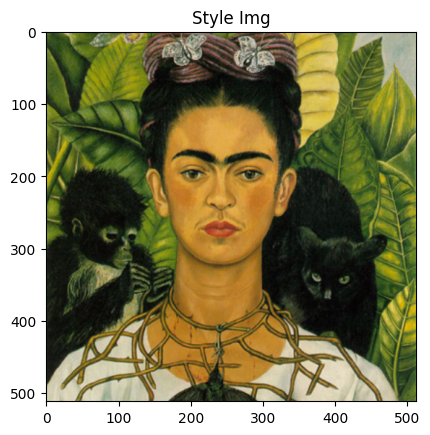

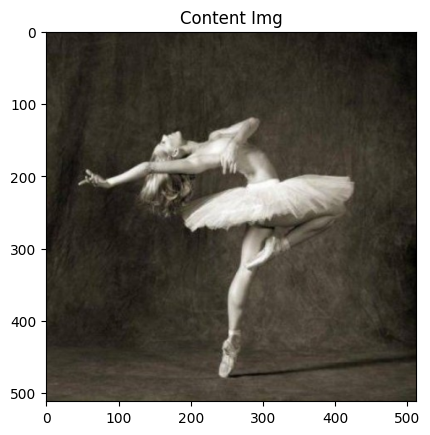

Executing image reconstruction from a white noise initialization.
Constructing the model…
run [50]:
Style Loss : 42.161148 Content Loss: 19.071924

run [100]:
Style Loss : 17.531948 Content Loss: 15.839466

run [150]:
Style Loss : 11.525565 Content Loss: 13.263502

run [200]:
Style Loss : 8.057673 Content Loss: 11.289028

run [250]:
Style Loss : 5.646019 Content Loss: 10.020350

run [300]:
Style Loss : 4.260124 Content Loss: 9.089248

Runtime of the program is 18.946038484573364


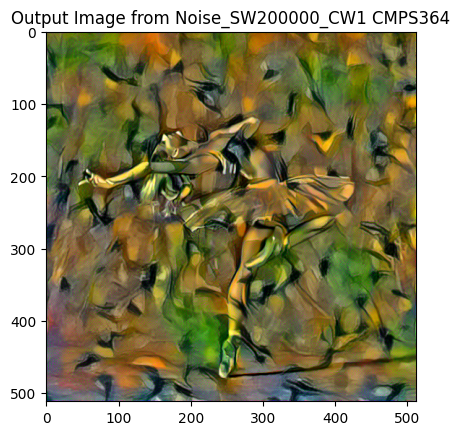

Saved /content/output/Output_Image_from_Noise_SW200000_CW1_style_transfer_CMPS364.png
Executing style transfer from a content image initialization
Constructing the model…
run [50]:
Style Loss : 13.881452 Content Loss: 8.727541

run [100]:
Style Loss : 6.917360 Content Loss: 7.667848

run [150]:
Style Loss : 3.937920 Content Loss: 7.208218

run [200]:
Style Loss : 2.493774 Content Loss: 6.991226

run [250]:
Style Loss : 1.774227 Content Loss: 6.818207

run [300]:
Style Loss : 1.350920 Content Loss: 6.725771

Runtime of the program is 19.184296131134033


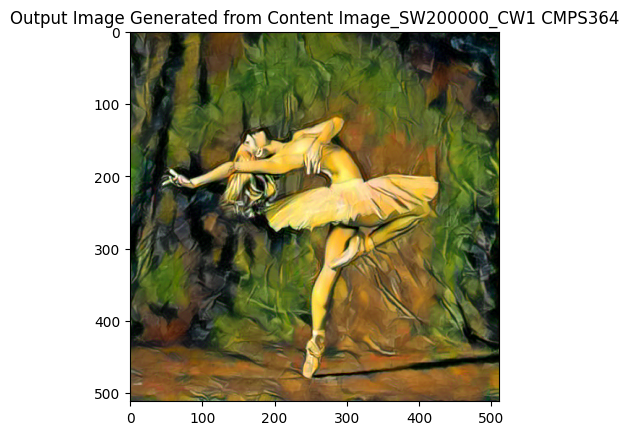

Saved /content/output/Output_Image_Generated_from_Content_Image_SW200000_CW1_style_transfer_CMPS364.png


In [19]:
def main(style_image_path, content_image_path, output_path):
    torch.cuda.empty_cache()
    # The images have been loaded for you.
    style_image = load_image(style_image_path)
    content_image = load_image(content_image_path)

    # Center crop the style_image to match the dimensions of the content image.
    if style_image.size(dim=1) != 3:
        style_image = style_image.repeat(1, 3, 1, 1)
    if content_image.size(dim=3) > style_image.size(dim=3):
        pad_size = math.ceil((content_image.size(dim=3) - style_image.size(dim=3)) / 2.0)
        padding = transforms.Pad((pad_size, pad_size), padding_mode="reflect")
        style_image = padding(style_image)
    if content_image.size(dim=2) > style_image.size(dim=2):
        pad_size = math.ceil((content_image.size(dim=2) - style_image.size(dim=2)) / 2.0)
        padding = transforms.Pad((0, 0, pad_size, pad_size), padding_mode="reflect")
        style_image = padding(style_image)


    centerCrop = transforms.CenterCrop((content_image.size(dim=2), content_image.size(dim=3)))
    style_image = centerCrop(style_image)
    plt.ion()

    assert style_image.size() == content_image.size(), \
        "We need to import the style and content images at the same size."

    # Display the original input image: (style image)
    plt.figure()
    img_show(style_image, title='Style Img')

    # Display the content image:
    plt.figure()
    img_show(content_image, title='Content Img')

    # We load a pre-trained VGG19 model from the PyTorch models library,
    # utilizing only the feature extraction component (convolutional layers)
    # and set it to evaluation mode.
    cnn = models.vgg19(pretrained=True).features.to(device).eval()

    print("Executing image reconstruction from a white noise initialization.")

    # style transfer

    start = time.time()
    input_image = torch.rand_like(content_image, device=device)
    output = run_optim(cnn, content_image, style_image, input_image, use_content=True, use_style=True,
                              weight_style=weight_style, weight_content=weight_content)
    print(f"Runtime of the program is {time.time() - start}")

    tag="CMPS364"
    combo="style_transfer"
    fig = plt.figure()
    title = 'Output Image from Noise' + "_SW" + str(weight_style) + "_CW" + str(weight_content)
    img_show(output, title=title + ' ' + tag)
    title += "_" + combo
    save_images(fig, output_path, title, tag)

    print("Executing style transfer from a content image initialization")
    start = time.time()
    input_image = content_image.clone()
    output = run_optim(cnn, content_image, style_image, input_image, use_content=True, use_style=True,
                              weight_style=weight_style, weight_content=weight_content)
    print(f"Runtime of the program is {time.time() - start}")


    fig = plt.figure()
    title = 'Output Image Generated from Content Image' + "_SW" + str(weight_style) + "_CW" + str(weight_content)
    img_show(output, title=title + ' ' + tag)
    title += "_" + combo
    save_images(fig, output_path, title, tag="CMPS364")

    plt.ioff()

output_dir = '/content/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_images(fig, dir, name, tag):
    name = name.replace(" ", "_")
    path = os.path.join(dir, '{:s}_{:s}.png'.format(name, tag))
    fig.savefig(path)
    print('Saved {}'.format(path))

if __name__ == '__main__':
    # Pass here your style image, content image, and the output path.
    main("/content/images/images/style/frida_kahlo.jpeg", "/content/images/images/content/dancing.jpg", "/content/output")

Interpretation:

When we apply style transfer on a white noise image, we will get an image that has content and style from content image and style image respectively, but the image itself is noisy and not very clear because we didn't catch the whole content. In fact, starting from a random noise will require a lot of optimization steps specially in style, and we will fail to converge while minimizing content loss.

When we apply style transfer on an image that is cloned from the content one, we will get a very accurate output which has content from content image (already similar) and style from the style image. In fact, the optimization will be done for style, and regarding content it will be faster as the input image looks very similar to the content.